In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import mlflow
import mlflow.sklearn

In [4]:
# Load data
df = pd.read_csv("completed_Apples_stock price dataset.csv" )
df.head(3)

,Unnamed: 0.1,Unnamed: 0,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment,date,time
0,0,4,2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077,2010-01-01,04:00:00
1,1,5,2010-01-01 05:00:00,99.022103,8011.832789,3004.510779,2.321292,4.095568,1.664753,-0.828119,2010-01-01,05:00:00
2,2,6,2010-01-01 06:00:00,108.127409,8028.157784,3010.735533,2.626140,5.447153,2.995546,-0.813849,2010-01-01,06:00:00


In [5]:
import json
try:
    with open("model_scores.json", "r") as f:
            final_scores = json.load(f)
except FileNotFoundError: 
    final_scores = {}   # start fresh if file doesn't exist

In [6]:
y = df['stock_price']
#x = df[["nasdaq_index", "sp500_index", "inflation_rate", "unemployment_rate", "interest_rate", "market_sentiment"]]
x = df[["nasdaq_index",  "market_sentiment"]]

In [7]:
# data splitting : 80% train, 20% test
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]
train_exog, test_exog = x[:train_size], x[train_size:]
train_size, train.shape, test.shape, train_exog.shape, test_exog.shape

(40473, (40473,), (10119,), (40473, 2), (10119, 2))

C:\Users\YOGITA\miniconda3\envs\DSENV\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


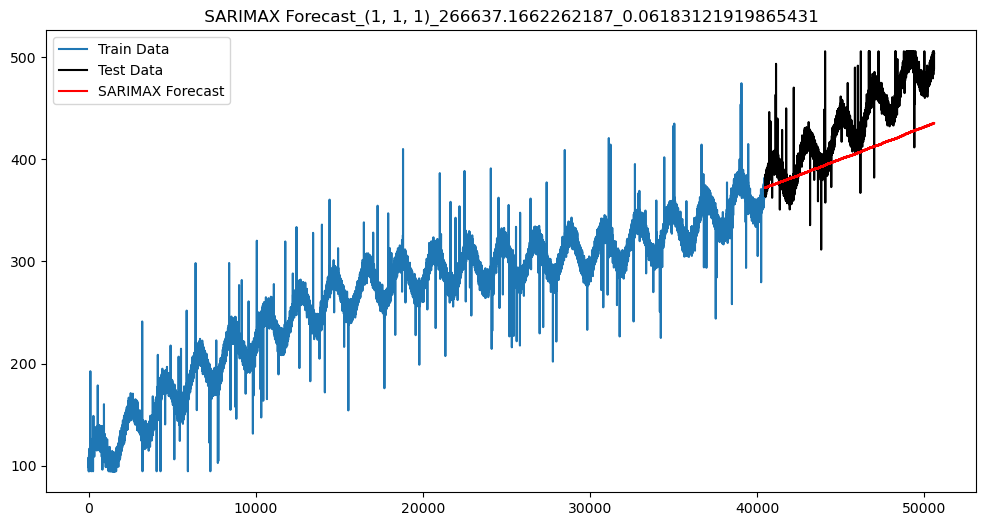

2026/01/31 09:26:12 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/31 09:26:12 INFO mlflow.store.db.utils: Updating database tables
2026/01/31 09:26:12 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/31 09:26:12 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/31 09:26:13 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/31 09:26:13 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/31 09:26:13 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or 

(1, 1, 1) 266637.1662262187 266697.4227099937 36.941138592819186 0.06183121919865431


C:\Users\YOGITA\miniconda3\envs\DSENV\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


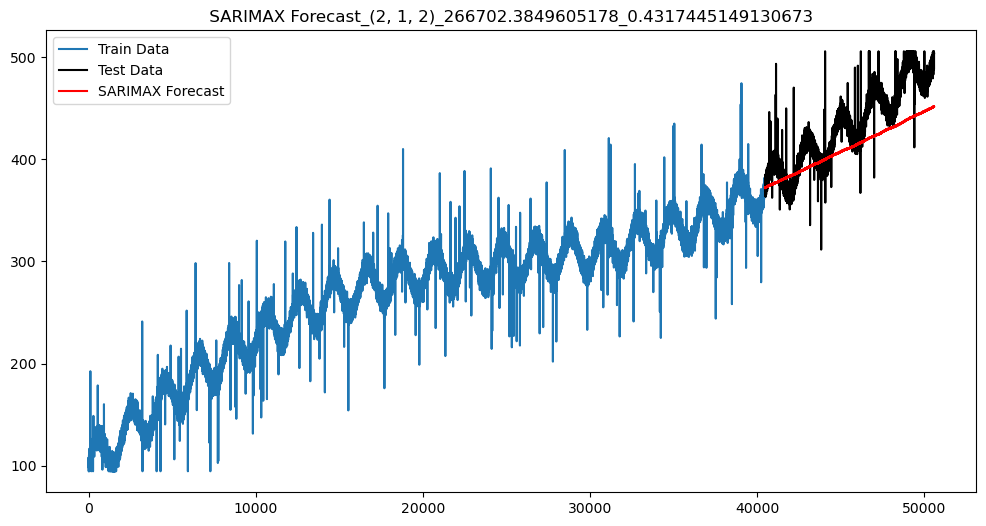

(2, 1, 2) 266702.3849605178 266779.8575825143 28.750248763351486 0.4317445149130673


C:\Users\YOGITA\miniconda3\envs\DSENV\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


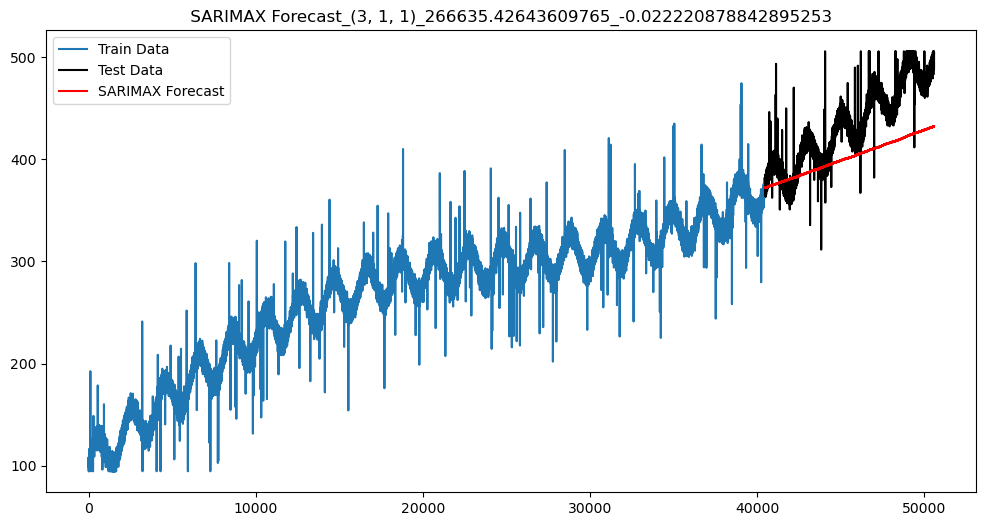

(3, 1, 1) 266635.42643609765 266712.89905809413 38.56045609900811 -0.022220878842895253


In [8]:
# modelling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error

best_config = None
best_aic = float("inf")
best_rmse = float("inf")
best_r2 = float("inf")
best_mae = float("inf")

orders = [(1,1,1), (2,1,2), (3,1,1)]  # (p,d,q)
#orders = [(3,1,1)]
for order in orders:
    sarima_model = SARIMAX(train, order=order, seasonal_order=(1,1,1,12), exog=train_exog) # build SARIMAX with exogeneous data
    sarima_model_fit = sarima_model.fit()
    sarima_forecast = sarima_model_fit.forecast(steps=len(test), exog=test_exog)

    AIC = sarima_model_fit.aic
    BIC = sarima_model_fit.bic        
    RMSE = root_mean_squared_error(test, sarima_forecast)
    MAE = mean_absolute_error(test, sarima_forecast)
    r2   = r2_score(test, sarima_forecast)

    # --- Plot comparison ---
    plt.figure(figsize=(12,6))
    plt.plot(train.index, train, label="Train Data")
    plt.plot(test.index, test, label="Test Data", color="black")    
    plt.plot(test.index, sarima_forecast, label="SARIMAX Forecast", color="red")
    plt.legend()
    plt.title(f" SARIMAX Forecast_{order}_{AIC}_{r2} ")
    plt.savefig(f"SARIMAX_{order}_{AIC}_{r2}.png")     
    plt.show()
    plt.close()
    
    with mlflow.start_run(run_name=f"SARIMAX_{order}"):
        mlflow.log_param("order", order)        
        mlflow.log_metric("AIC", float(AIC))
        mlflow.log_metric("BIC", float(BIC))
        mlflow.log_metric("RMSE", float(RMSE))
        mlflow.log_metric("r2Square", float(r2))
        mlflow.log_artifact(f"SARIMAX_{order}_{AIC}_{r2}.png") 
        mlflow.sklearn.log_model(sarima_model, name="SARIMAX")
    
        # Track best model
    if AIC < best_aic:
        best_aic = AIC
        best_rmse = RMSE
        best_mae = MAE
        best_r2 = r2
        best_config = (order)
    
    print( order, AIC, BIC, RMSE, r2)

In [9]:
print("\nBest ETS configuration:")
print(f"Order={best_config} | AIC={best_aic:.2f}, RMSE={best_rmse:.2f}")
final_scores["SARIMAX"] = {"AIC": best_aic, "RMSE": best_rmse, "R2": best_r2, "MAE": best_mae }


Best ETS configuration:
Order=(3, 1, 1) | AIC=266635.43, RMSE=38.56


C:\Users\YOGITA\miniconda3\envs\DSENV\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


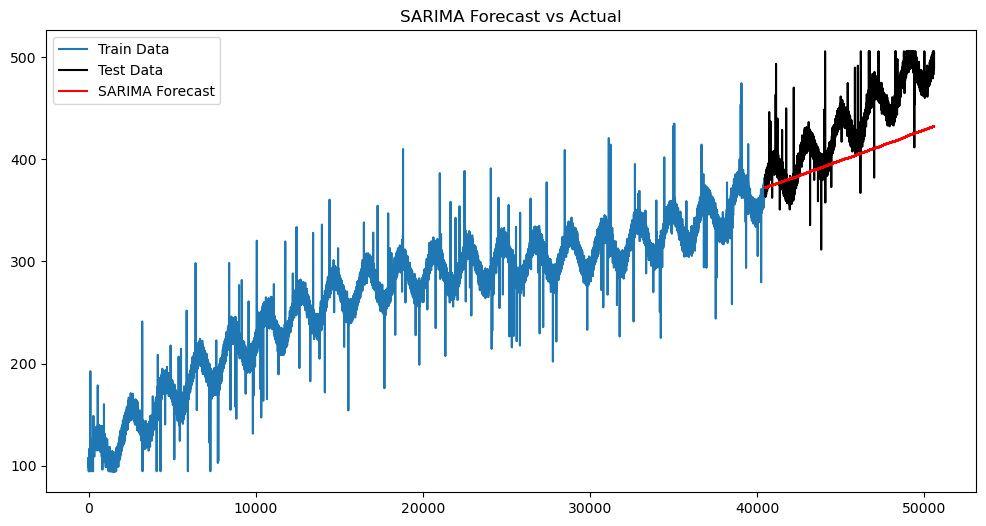

In [10]:
sarima_model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,1,12), exog=train_exog)
sarima_model_fit = sarima_model.fit()
sarima_forecast = sarima_model_fit.forecast(steps=len(test), exog=test_exog)

# --- Plot comparison ---
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train Data")
plt.plot(test.index, test, label="Test Data", color="black")
plt.plot(test.index, sarima_forecast, label="SARIMA Forecast", color="red")
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()


In [11]:
import json

# Save model score
with open("model_scores.json", "w") as f:
    json.dump(final_scores, f, indent=4)